# Introduction

## Motivation

We decided to measure the overal livability of the different neighborhoods in the City of Pittsburgh by analyzing the access to various facilities or the presence of pedestrian-centered infrastructure in a given neighborhood. We believe the following metrics to be rather significant in measuring and determining the quality of life in a neighborhood.

# Our Metrics
We chose three different measurements to identify the best neighborhood in Pittsburgh.
1. Walkability
2. Access to food
3. Park availability
<br>
<br>Each neighborhood would have a given score that represents the combined scores of all three metrics with the higher score representing the better neighborhood.

In [2]:
## import all libraries to use for the whole notebook

import pandas as pd
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

## Metric: Walkability | by Greg Six

For our analysis we decided to take a look at the general quality of life across areas in Pittsburgh, and my corner of that analysis was to assess the amount of pedestrian infrastructure. To do that, I found a dataset that measured the ratio of sidewalks to streets in various blockgroups throughout Pittsburgh. 

If you assume that the goal of making an area "walkable" is at least placing a sidewalk on both sides of any given street, then the ratio to shoot for would be at least 2:1.

One problem with my dataset, however, was that it measured this ratio by GEOIDs, not neighborhoods. So I looked these up to see if I could pull the neighborhood from the GEOIDs it gave me. While there are GEOIDs that can identify zipcodes, the ones I had did not. They identified census blockgroups, and even if they did instead identify zipcodes, I would still need a way to quickly connect zipcode to neighborhood for processing all of the given data. Either way I needed a second spreadsheet to connect the data.

Seeing as my GEOIDs identified census blockgroups, I poked around for a spreadsheet that connected the blockgroups to zipcodes at least, but I found one that directly connected them to their respective neighborhoods, making things much easier for me.

In [4]:
## load in spreadsheets to analyze

walk   = pd.read_csv("sidewalkstreetratioupload.csv")
zcodes = pd.read_csv("9756af5f-3320-4601-84e2-347d64071e25.csv")

Then I went ahead and merged both of those dataframes on their GEOID columns.

In [5]:
walkhoodgeo = pd.merge(walk, zcodes, left_on = "GEOID", right_on = "geoid10")

At that point I had a lot of columns of data that I didn't need, so I went and just got rid of them.

In [6]:
walkhoodgeo = walkhoodgeo.loc[:, ["Ratio", "hood", "GEOID"]]

walkhoodgeo = walkhoodgeo.sort_values(by=['hood'])

## View all data in dataframe to check data
## print(hoodwalk.to_string())

At this point I hit a problem; there can be multiple blockgroups in a single neighborhood. Meaning that I had multiple ratio measurements for some neighborhoods that I had to combine into one measurement for the whole neighborhood.

To do this, I made an empty dictionary and a loop. The loop places each neighborhood into the dictionary as a key, and its ratio as its corresponding value. If it hits a duplicate neighborhood, the two ratios are added together and divided by 2 to create the new ratio for both of the blockgroups combined, and it continues until there are no more duplicates and every neighborhood and ratio is entered.

In [8]:
## loop to combine the ratios of neighborhood that contain more than one blockgroup

combDupes={}
for index, row in walkhoodgeo.iterrows():
    hood = row['hood']
    if hood in combDupes:
        combDupes[hood] = (combDupes[hood] + row['Ratio']) / 2
    else:
        combDupes[hood] = row['Ratio']
    

## display resulting dictionary to check data
## combDupes

Then I crammed the resulting dictionary into a new dataframe.

In [9]:
## create dataframe and fill it with the combDupes dictionary

walkhood = pd.DataFrame(combDupes.items())
walkhood.columns = ['Neighborhood', 'Ratio']

## display dataframe to check data
## print(walkhood.to_string())

Then to help visualize the results, I loaded up the shape file of the City of Pittsburgh from the data visualization lab.

In [10]:
## load up shape file to map the data

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

## make sure the map loads properly
## neighborhoods.plot()

Next up I merged the neighborhood map data with my data.

In [11]:
## merge neighborhood shape file with walkability ratio data

walkmap = neighborhoods.merge(walkhood, how='left', left_on='hood',
                              right_on='Neighborhood')

## check for successful merge
## walkmap[['Neighborhood','Ratio','geometry']].head()

Then we finally get to plot the results on a map of Pittsburgh

(yes this was just copypasted from the data visualizaton lab, ain't broke don't fix it etc.)

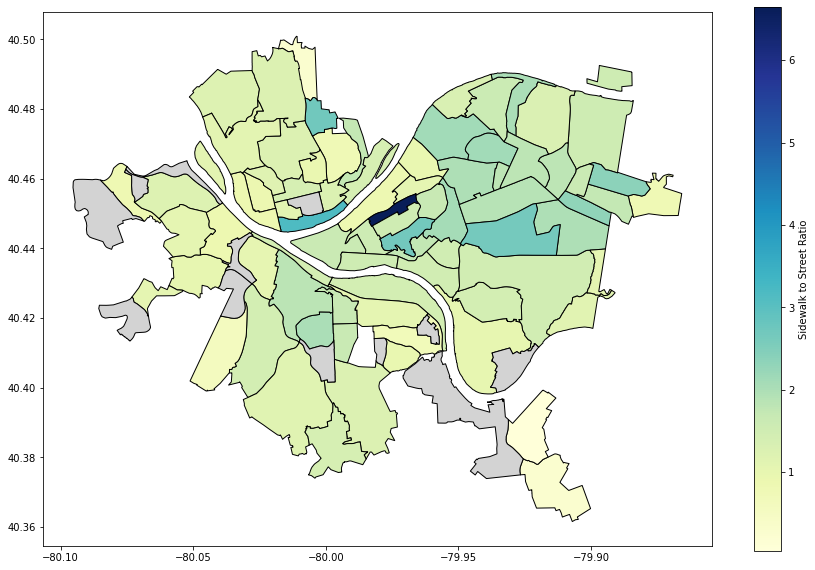

In [15]:
walkmap.plot(column='Ratio',
               cmap='YlGnBu',
               edgecolor="black", 
               legend=True,
               legend_kwds={'label': "Sidewalk to Street Ratio"},
               figsize=(15, 10),
               missing_kwds={"color": "lightgrey"}
               )

And while a heatmap is useful for a quick visual understanding, this doesn't declare the neighborhoods by name, so I bargraphed the results as well.

Text(0, 0.5, 'Sidewalk to Street Ratio')

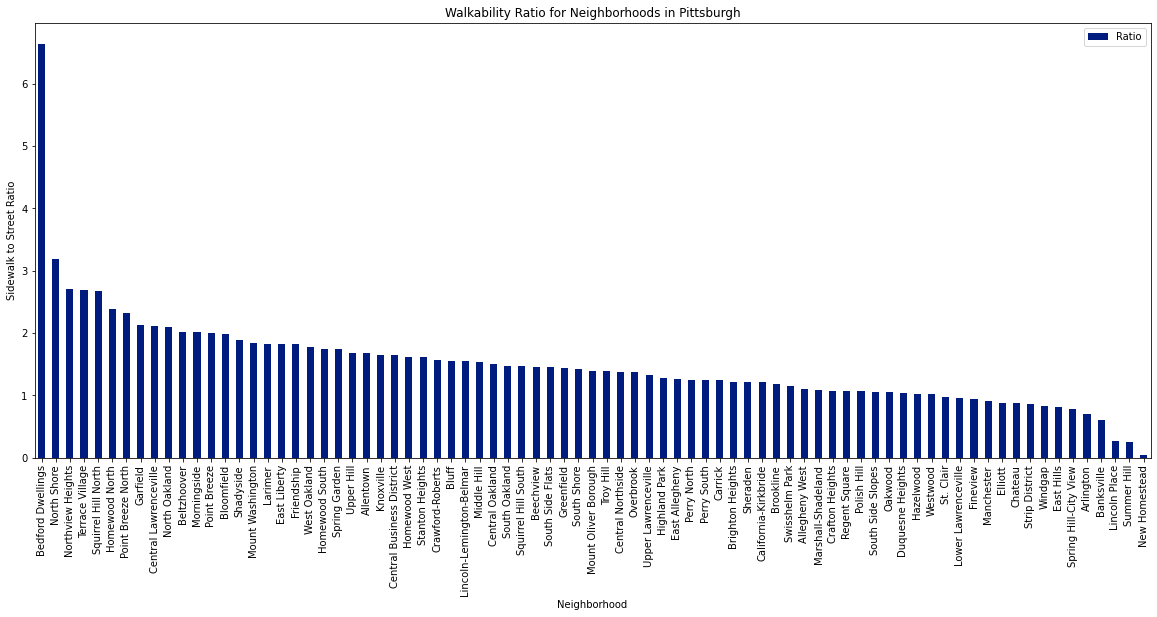

In [13]:
## plot the data with a bargraph
## plus visual formatting and sorting

walkhood.sort_values(by=['Ratio'], inplace=True, ascending=False)
plt.rcParams['figure.figsize'] = [20, 8]
plt.style.use('seaborn-dark-palette')
walkhood.plot.bar(x="Neighborhood", y="Ratio")
plt.title("Walkability Ratio for Neighborhoods in Pittsburgh")
plt.xlabel("Neighborhood")
plt.ylabel("Sidewalk to Street Ratio")

Then we'll zoom in on the top 10 for an easier comparison.

Text(0, 0.5, 'Sidewalk to Street Ratio')

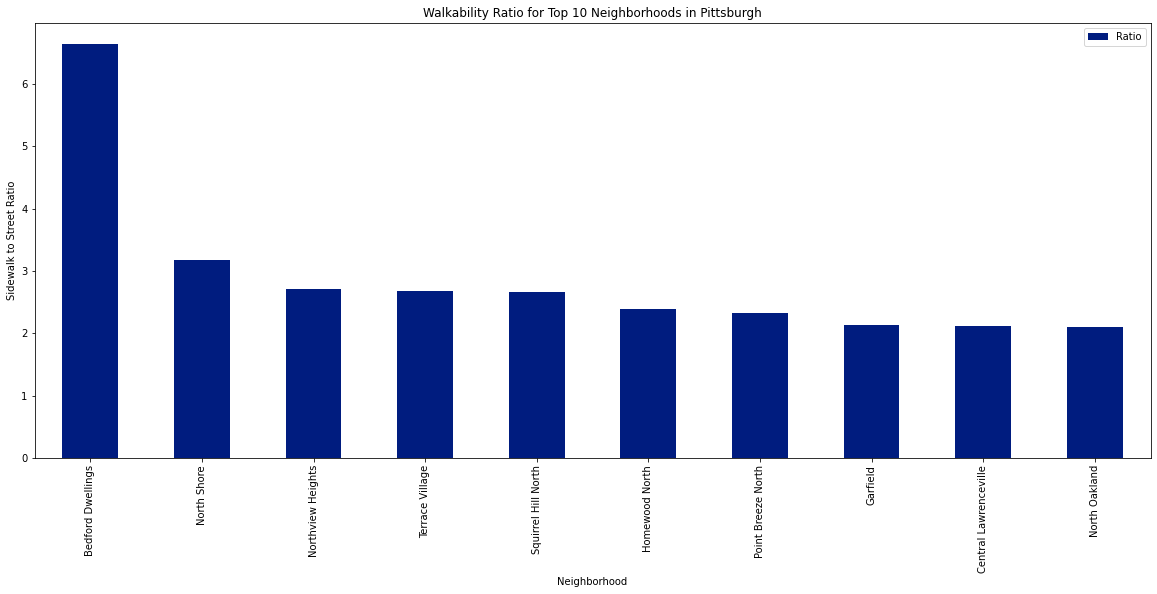

In [14]:
walkhood.head(10).plot.bar(x="Neighborhood", y="Ratio")
plt.title("Walkability Ratio for Top 10 Neighborhoods in Pittsburgh")
plt.xlabel("Neighborhood")
plt.ylabel("Sidewalk to Street Ratio")

### Conclusion

At this point, we can clearly conclude that Bedford Dwellings has by far the highest sidewalk-to-street ratio. This jump was so extreme that I thought it might've been some odd outlier caused by some of my processing, but when I went back to check the spreadsheet itself, this is a lone datapoint for a single blockgroup, so it is what it is.

(Side comment, I thought it was interesting how many of the top neighborhoods had "north" in their name. Maybe a coincidence, maybe there's a greater implication to explore by analyzing some other data collections? Who knows.)

Clearly simplying measuring how much sidewalk compared to street exists in a given neighborhood isn't a perfect indicator of walkability or pedestrian quality of life. To get a better overall picture you might want to also take a look at public transit infrastructure as well, but that's outside of the scope of this project.

For now though, if you really wanna be able to brag about living in the neighborhood with the highest sidewalk-to-street ratio, check out Bedford Dwellings.

## Metric: Fire Frequency | by Andre Nguyen
We are going to use the fire incidents dataset to map and count how many fires occur on each neighborhood. In terms of livability, the more fires, the worse it will be. On the contrary, the smaller amount of fires in neighborhood is will give a better score.

In [5]:
fires = pd.read_csv("fire.csv", sep=",")
fires.head()

,call_no,incident_type,type_description,address,alarm_time,alarms,primary_unit,census_tract,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,F160029985,111.0,Building fire,"800 BLOCK CENTER ST, WILKINSBURG PA 15221",2016-04-21T05:01:04,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-16,40.441275,-79.882485
1,F180022058,111.0,Building fire,"1100 BLOCK JANE ST, WILKINSBURG PA 15221",2018-03-13T08:34:43,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-21,40.436342,-79.881003
2,F180022102,131.0,Passenger vehicle fire,"SB STATE HWY 28 SB AT 31S, PITTSBURGH PA 15212",2018-03-13T11:54:23,0,231EN32,2406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-1A,NaN,NaN
3,F170043431,131.0,Passenger vehicle fire,"1700 BLOCK BELLEAU DR, PITTSBURGH PA 15212",2017-05-31T08:39:47,0,231EN38,2509.0,Fineview,6.0,25.0,4.200325e+10,1.0,25.0,1.0,1-10,40.460303,-80.006980
4,F180021111,111.0,Building fire,"2400 BLOCK VILLAGE RD, PITTSBURGH PA 15205",2018-03-09T10:26:42,1,231EN31,2808.0,Fairywood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-16,40.449009,-80.076607


In [6]:
Dict={}
for index, row in fires.iterrows():
    zipcode = row['neighborhood']
    if zipcode in Dict:
        Dict[zipcode]+=1
    else:
        Dict[zipcode]=1

The important information we want to extract from this dataset is the neighborhoods. For each neighborhood we will count how many fires are identified with that neighborhood. We want a total count for each neighborhood.

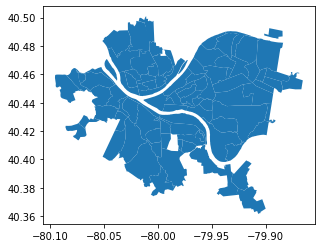

In [8]:
neighborhoods=geopandas.read_file("Neighborhoods_.shp")
neighborhoods.plot()

In [9]:
finalfreq=pd.DataFrame(Dict.items())
finalfreq.columns = ['Neighborhood', 'Fire Frequency']
finalfinal=finalfreq.loc[1:,:]
finalfinal['Fire Frequency'] = pd.to_numeric(finalfinal['Fire Frequency'], errors='coerce')
finalfinal = finalfinal.dropna(subset=['Fire Frequency'])

<ipython-input-9-40e16aaf07d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalfinal['Fire Frequency'] = pd.to_numeric(finalfinal['Fire Frequency'], errors='coerce')


We want to drop all data that has 'NaN' as the neighborhood because these data points are irrelevant and unusable. 

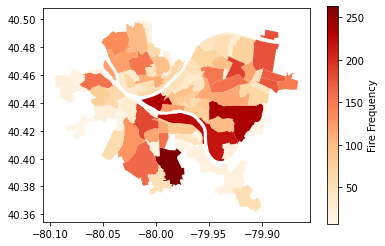

In [10]:
finalfinal=finalfinal.loc[:,["Neighborhood","Fire Frequency"]]
firefrequencymap=neighborhoods.merge(finalfinal, how="left", left_on="hood",right_on="Neighborhood")
firefrequencymap.plot(column='Fire Frequency',
            cmap='OrRd',
            legend=True,
            legend_kwds={'label':"Fire Frequency"},
            )

This heatmap shows a heatmap of how many fires are occurring in Pittsburgh neighborhoods. Carrick and Squirrel Hill South has the most fires in Pittsburgh. They will get lower scores because of so.

Text(0, 0.5, 'Fire Frequency')

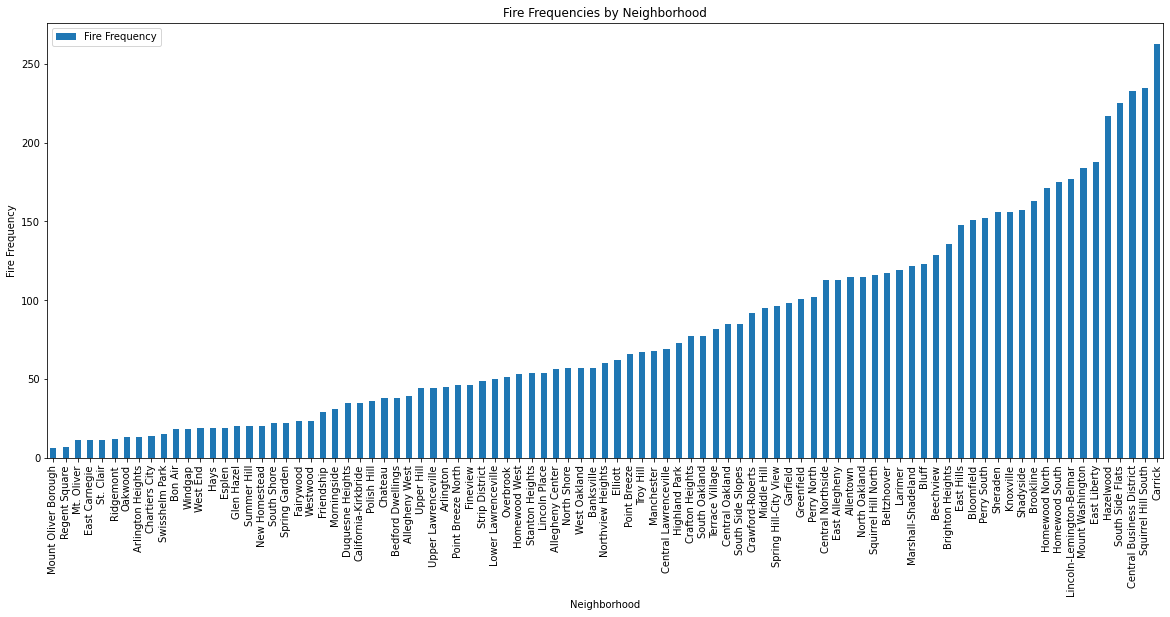

In [12]:
finalfinal.sort_values(by=['Fire Frequency'], inplace=True, ascending=True)
plt.rcParams['figure.figsize']=[20,8]
finalfinal.plot.bar(x="Neighborhood",y="Fire Frequency")
plt.title("Fire Frequencies by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Fire Frequency")

Above is a chart of all the neighborhoods graphed with how many fires had occurred in that neighborhood. Below is a chart of the bottom ten neighborhoods.

Text(0, 0.5, 'Fire Frequency')

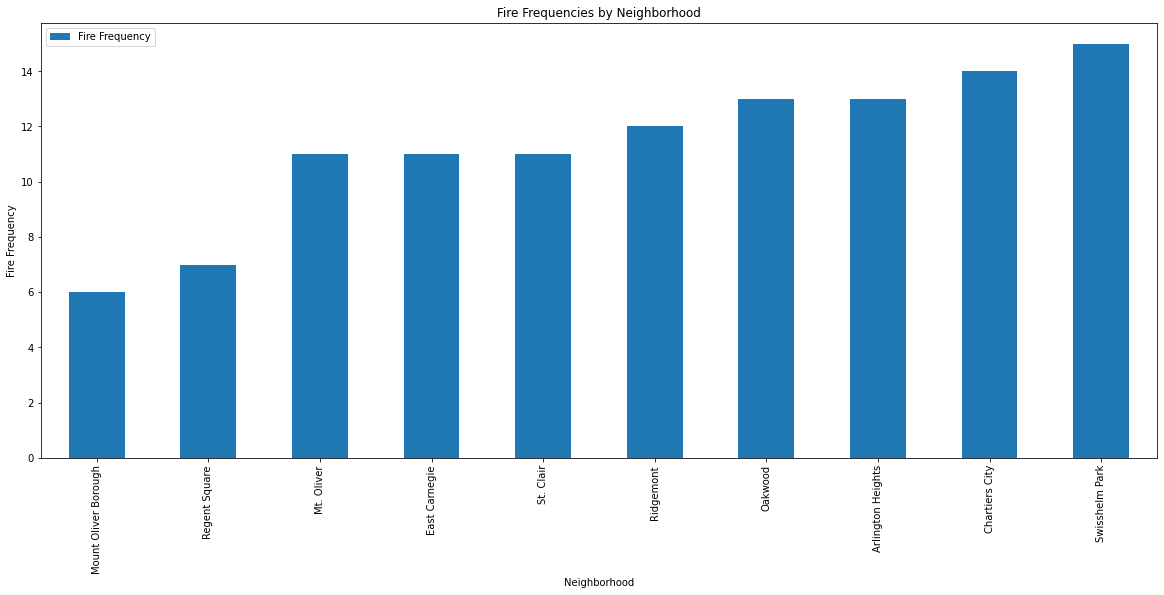

In [13]:
finalfinal.head(10).plot.bar(x="Neighborhood",y="Fire Frequency")
plt.title("Fire Frequencies by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Fire Frequency")

#### Scoring
In order to score each neighborhood, we are going to divide the total number of fires that neighborhood had by 30, giving us a score out of 10. This score out of 10 will add to the total overall score.

In [14]:
finalfinal['Score']=finalfinal['Fire Frequency']/30
print(finalfinal.to_string())

                 Neighborhood  Fire Frequency     Score
84       Mount Oliver Borough               6  0.200000
62              Regent Square               7  0.233333
91                 Mt. Oliver              11  0.366667
86              East Carnegie              11  0.366667
85                  St. Clair              11  0.366667
73                  Ridgemont              12  0.400000
89                    Oakwood              13  0.433333
87          Arlington Heights              13  0.433333
90             Chartiers City              14  0.466667
58             Swisshelm Park              15  0.500000
68                    Bon Air              18  0.600000
45                    Windgap              18  0.600000
71                   West End              19  0.633333
78                       Hays              19  0.633333
76                     Esplen              19  0.633333
69                 Glen Hazel              20  0.666667
75                Summer Hill              20  0

## Metric: Park Availability | by Vince Sangpachatanaruk

I wanted to measure the best quality of life of a neighborhood by calculating each neighborhood's combined park area, and the best neighhorhood would be the one with the biggest combined park area, but my data did not contain the area for each park. My data did, however, contain which neighborhood the parks are located in, so I will be measuring the best quality of life of a neighborhood by calculating the number of parks in each neighborhood, and the neighborhood with the most parks is the best neighborhood.

## Calculations

Import pandas library to work with data sets

In [8]:
import pandas as pd

<br>
Load in the City of Pittsburgh Parks Data

In [9]:
data = pd.read_csv("parks.csv")

# look at the first ten rows of the data
data.head(10)

,id,name,type,maintenance_responsibility,image,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,2111959181,Able Long Park,Park,Parks - Southern,https://tools.wprdc.org/images/pittsburgh/park...,Beechview,4,19,42003192000,5,19,6,4-28,40.408118,-80.028197
1,1109513049,Albert Turk Graham Park,Park,Parks - Schenley,https://tools.wprdc.org/images/pittsburgh/park...,Crawford-Roberts,6,3,42003030500,3,3,2,2-1,40.440507,-79.984018
2,1544096765,Alcoa Park,Park,Parks - Northern,NaN,North Shore,1,22,42003563200,6,22,1,1-20,40.447481,-80.001017
3,1212681573,Allegheny Commons,Park,Parks - Northern,NaN,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.453126,-80.009158
4,954863286,Allegheny Landing Park,Park,Parks - Northern,NaN,North Shore,1,22,42003563200,6,22,1,1-20,40.447184,-80.002907
5,223959093,Allegheny Riverfront Park,Park,Parks - Northern,NaN,Central Business District,6,2,42003020100,6,2,2,1-3,40.444591,-80.002416
6,1596467340,Alpine Gardens Park,Park,Parks - Northern,https://tools.wprdc.org/images/pittsburgh/park...,Central Northside,6,25,42003250300,1,25,1,1-21,40.457673,-80.012852
7,1829922263,Alton Park,Park,Parks - Southern,NaN,Beechview,4,19,42003191600,5,19,6,4-28,40.414580,-80.021855
8,2049886968,Amber Triangle,Traffic Island/Median,2nd Division,NaN,East Liberty,7,8,42003111500,2,8,5,3-23,40.459099,-79.931846
9,1047118140,Ammon Park,Park,Parks - Schenley,NaN,Bedford Dwellings,6,5,42003050900,3,5,2,2-5,40.449526,-79.978247


<br>
Delete unwanted data. Data will only contain park name, type, and neighborhood which the park is located in. 

In [10]:
data1 = data[['name', 'type', 'neighborhood']]
data1.head(20)

,name,type,neighborhood
0,Able Long Park,Park,Beechview
1,Albert Turk Graham Park,Park,Crawford-Roberts
2,Alcoa Park,Park,North Shore
3,Allegheny Commons,Park,Allegheny Center
4,Allegheny Landing Park,Park,North Shore
5,Allegheny Riverfront Park,Park,Central Business District
6,Alpine Gardens Park,Park,Central Northside
7,Alton Park,Park,Beechview
8,Amber Triangle,Traffic Island/Median,East Liberty
9,Ammon Park,Park,Bedford Dwellings


<br>
Data must only contain parks that have the type park.

In [11]:
parkData = data1.loc[data1['type'] == "Park"] 
parkData.head(20)

,name,type,neighborhood
0,Able Long Park,Park,Beechview
1,Albert Turk Graham Park,Park,Crawford-Roberts
2,Alcoa Park,Park,North Shore
3,Allegheny Commons,Park,Allegheny Center
4,Allegheny Landing Park,Park,North Shore
5,Allegheny Riverfront Park,Park,Central Business District
6,Alpine Gardens Park,Park,Central Northside
7,Alton Park,Park,Beechview
9,Ammon Park,Park,Bedford Dwellings
10,Arlington Park,Park,South Side Slopes


<br>
Make a new dataFrame with the first column being all the unique neighborhood names. Another associated column will be the occurances of the neighborhood name within the park data.

In [12]:
nbhd = parkData['neighborhood'].value_counts()
nbhd.head(10)

Beechview             6
South Side Slopes     6
Troy Hill             5
Hazelwood             5
Mount Washington      5
Elliott               4
Sheraden              4
Marshall-Shadeland    4
East Liberty          4
Brighton Heights      3
Name: neighborhood, dtype: int64

<br>
Plot the data in a bar graph for better data visualization

Text(0, 0.5, 'Number of Parks')

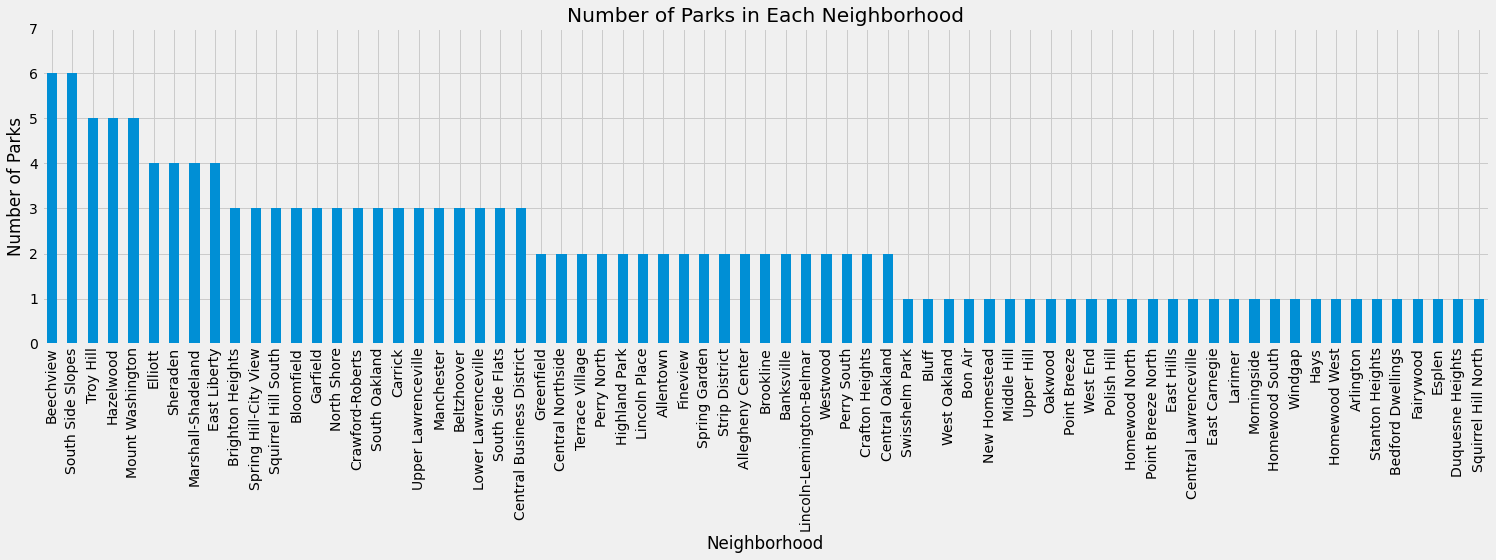

In [13]:
import matplotlib.pyplot as plt #import pyplot library for data visualization

# format and style
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [21, 8]
plt.rcParams["figure.autolayout"] = True

ax = nbhd.plot(kind='bar', linewidth=1, title = "Number of Parks in Each Neighborhood", ylim = [0, 7])

# set axis labels
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of Parks")


<br>
Zoom in on top ten neighborhoods for easier comparison

Text(0, 0.5, 'Number of Parks')

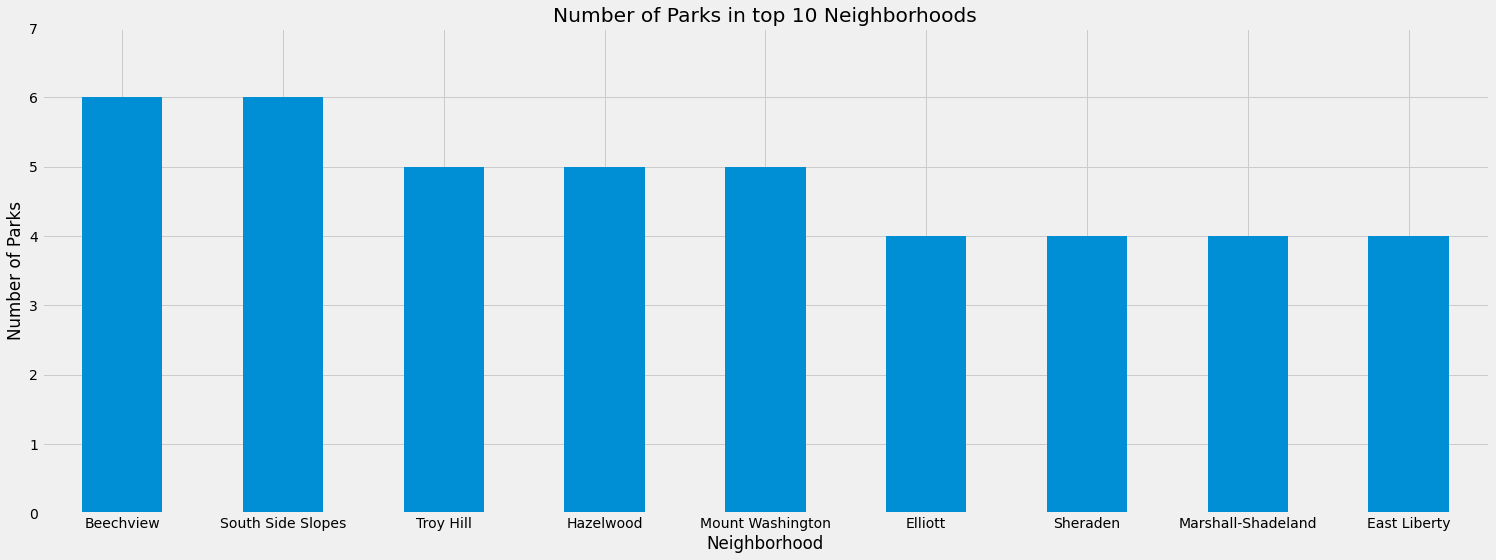

In [14]:
ax = nbhd.head(9).plot(kind='bar', linewidth=1, rot = 0, title = "Number of Parks in top 10 Neighborhoods", ylim = [0,7])
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of Parks")

## Data Visualization

Import geopandas for map visualization.

In [15]:
import geopandas

<br>
Create geopandas dataframe.

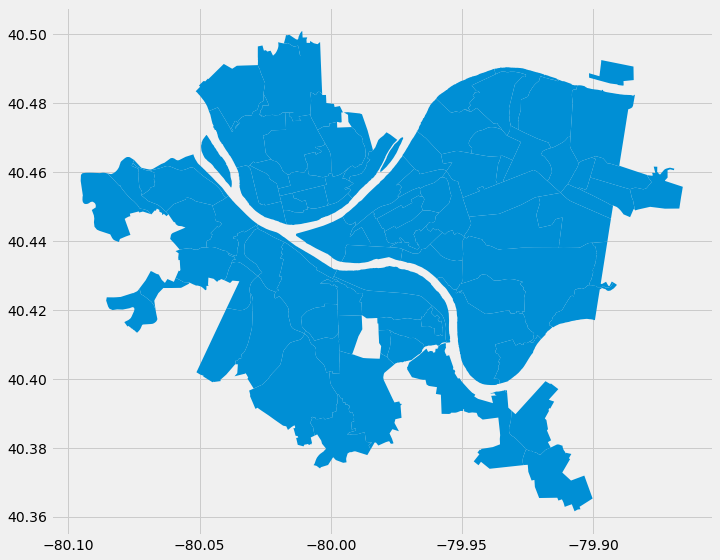

In [16]:
neighborhoods = geopandas.read_file("Neighborhoods_.shp") # read in the shapefile
neighborhoods.plot()

<br>
Convert nbhd dictionary to a dataframe. Also add column names.

In [17]:
nbhdDataFrame = pd.DataFrame(list(nbhd.items()), columns=['neighborhood', 'parks'])
nbhdDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   neighborhood  71 non-null     object
 1   parks         71 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


<br>
To make this map represent our data, we need to merge our parks dataframe with our map dataframe.

In [18]:
parks_map = neighborhoods.merge(nbhdDataFrame, how='left', left_on='hood', right_on='neighborhood')

<br>
Now each neighborhood has a park count, but it is hard to interpret from this current map.

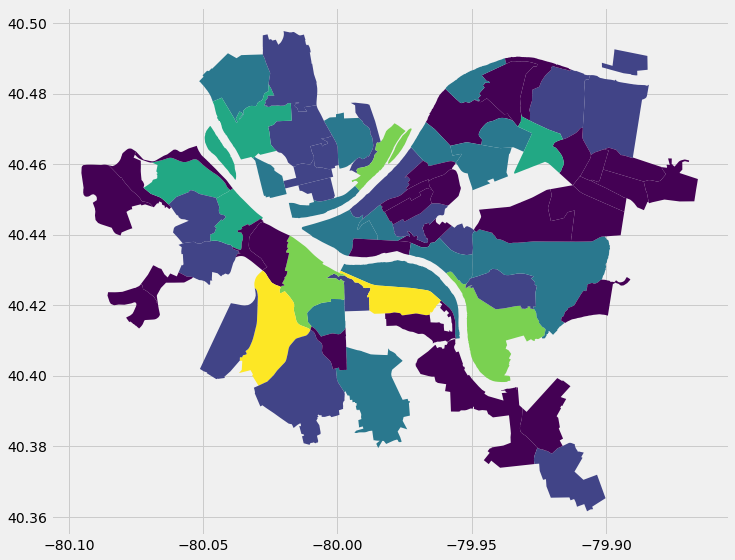

In [19]:
# draw a choropleth map using data from the column named "parks"
parks_map.plot(column='parks')

<br>
Set parameters for plot() to make a map that is both more functional and readable.

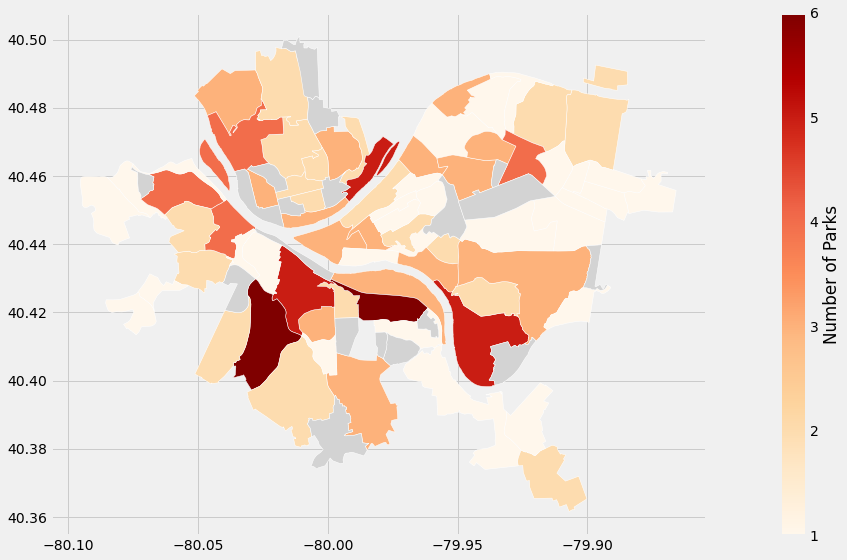

In [24]:
parks_map.plot(column='parks', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Parks"}, # label the legend
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )


## Conclusion

After analyzing the park data, I have come to a conclusion that South Side Slopes and Beechview are both the best neighborhoods in terms of quality of life. These two neighborhoods have six parks within them which is more than any other neighborhood in the data set. I can narrow this down even further by looking at the areas of South Side Slopes and Beechview. Out of the two, the neighborhood with the smaller area with be the best neighborhood because that means it takes people less time on average to travel to a park which is a better quality of life. South Side Slopes has an area of approximately 0.716 square miles, and Beechview has an area of approximately 1.460 square miles. South Side Slopes is the best neighborhoods in terms of quality of life.

## Combining Submetrics

We decided to weight our submetrics equally. We will score every neighborhood from 0 to 10 according to our submetrics. After that, we will combine all the scores, and visualize it with the 

In [32]:
nbhdDataFrame['score'] = nbhdDataFrame['parks'] / 6 * 10
nbhdDataFrame.head(40)

,neighborhood,parks,score
0,Beechview,6,10.000000
1,South Side Slopes,6,10.000000
2,Troy Hill,5,8.333333
3,Hazelwood,5,8.333333
4,Mount Washington,5,8.333333
5,Elliott,4,6.666667
6,Sheraden,4,6.666667
7,Marshall-Shadeland,4,6.666667
8,East Liberty,4,6.666667
9,Brighton Heights,3,5.000000
